<a href="https://colab.research.google.com/github/plataforma-fiscalizacion-CGR/Plataforma_fiscalizacion/blob/master/deteccion_actividad_humana(SALAMANCA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introducción
En este notebook, se busca reconocer y predecir la de actividad humana por medio de los resgitros que tiene registros de mediciones de aceleración y velocidad angular de diferentes aspectos físicos en las tres dimensiones espaciales (X, Y, Z) .Se hace de seguido un análisis exploratorio.

In [0]:
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

Se suben los archivos de datos.

In [40]:

from google.colab import files
uploaded = files.upload()

Saving human-activity-recognition-with-smartphones.zip to human-activity-recognition-with-smartphones.zip


In [49]:
!unzip human-activity-recognition-with-smartphones.zip

Archive:  human-activity-recognition-with-smartphones.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


Se cargan los datos de entrenamiento y testeo.

In [124]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print('Entrenamiento', train.shape,'\n', train.columns)
print('\nTesteo', test.shape)

Entrenamiento (7352, 563) 
 Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

Testeo (2947, 563)


**Análisis exploratorio**
Los datos tienen 7352 observaciones con 563 variables con las primeras columnas que representan las desviaciones medias y estándar de las aceleraciones corporales en 3 dimensiones espaciales (X, Y, Z). Las dos últimas columnas son "sujeto" y "actividad", que representan el sujeto del que se toma la observación y la actividad correspondiente, respectivamente. Veamos qué actividades se han registrado en estos datos.Convenientemente los valores se ubican entre  −1  and  1 , lo cual podría significar que fueron reescalados.

In [125]:
print('Train labels', train['Activity'].unique(), '\nTest Labels', test['Activity'].unique())

Train labels ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS'] 
Test Labels ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [61]:
train.tail()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,0.029369,-0.076700,0.273480,0.186626,0.266917,0.000698,-0.674986,-0.788077,-0.473463,-0.501092,-0.166197,0.034015,0.195643,0.140158,-0.082077,-0.561607,0.426433,-0.078255,-0.056751,-0.094106,0.099141,-0.119821,0.293112,-0.425386,0.267986,-0.205315,0.142117,-0.211822,-0.251582,-0.283335,...,0.354983,-0.904762,-0.066650,-0.076714,-0.426588,-0.332753,-0.129727,-0.128549,-0.251258,-0.995117,-0.332753,-0.605727,-0.292601,0.577573,-0.897436,-0.376234,-0.170845,-0.551898,-0.681097,-0.723951,-0.647418,-0.799450,-0.925241,-0.681097,-0.951092,-0.599074,0.310836,-0.904762,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,30,WALKING_UPSTAIRS
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,0.029369,-0.031966,0.282174,0.202880,0.266917,-0.041310,-0.706359,-0.804546,-0.495789,-0.520057,-0.279863,0.026565,0.178138,0.293566,-0.051532,-0.361660,0.149854,0.206839,-0.154722,0.032725,-0.057240,0.034260,0.239835,-0.364480,0.121335,0.188717,-0.207505,-0.198555,-0.225866,-0.274504,...,0.361739,-0.904762,-0.193946,-0.151879,-0.509448,-0.357992,-0.187114,-0.210320,-0.131733,-0.916112,-0.357992,-0.649987,-0.427577,0.620646,-0.846154,-0.296176,0.019626,-0.277183,-0.682756,-0.771183,-0.727039,-0.779350,-0.761880,-0.682756,-0.957032,-0.670062,0.207930,-0.904762,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,30,WALKING_UPSTAIRS
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,-0.110405,0.055411,0.263175,0.202880,0.264670,0.008034,-0.693162,-0.844279,-0.271194,-0.488620,-0.250723,0.334376,0.173131,0.276040,0.152003,-0.376773,0.200784,0.063584,-0.017019,-0.004323,-0.023053,0.119962,0.080689,-0.420093,0.197763,-0.033780,0.016677,-0.226826,-0.184700,-0.198452,...,0.189903,-0.904762,0.007099,0.331457,0.083984,-0.351948,-0.032290,-0.193130,0.167388,-0.972099,-0.351948,-0.545002,-0.241789,0.5

In [58]:
print('tamaño dataset entrenamiento: {}'.format(train.shape))
print('tamaño dataset testeo: {}'.format(test.shape))

tamaño dataset entrenamiento: (7352, 563)
tamaño dataset testeo: (2947, 563)


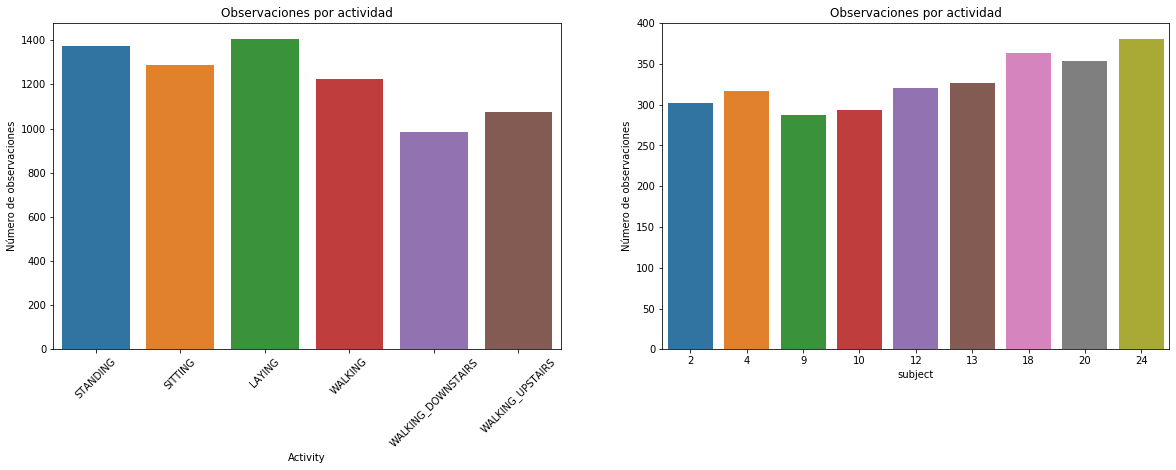

In [0]:
fig, ax = plt.subplots(ncols=2, figsize = (20,6))

sb.countplot(train['Activity'], ax=ax[0])
sb.countplot(test['subject'], ax=ax[1])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('Número de observaciones')
ax[0].set_title('Observaciones por actividad')
ax[1].set_ylabel('Número de observaciones')
ax[1].set_title('Observaciones por actividad')

plt.show()

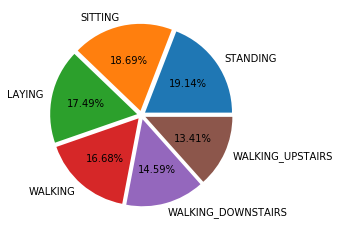

In [127]:
y_train=train['Activity']
activity_number=y_train.value_counts()
plt.pie(activity_number,labels=train['Activity'].unique(),explode=[0.05,0.05,0.05,0.05,0.05,0.05],autopct='%1.2f%%')
plt.show()

Tenemos 6 actividades, 3 pasivas (acostado, de pie y sentado) y 3 activas (caminar, caminar_escaleras, caminar_escaleras) que implican caminar. Por lo tanto, cada observación en el conjunto de datos representa una de las seis actividades cuyas características se registran en las 561 variables. Nuestro objetivo sería probar una máquina para predecir una de las seis actividades dado un conjunto de características de estas 561 variables.

Veamos cuántas observaciones registra cada sujeto.

In [9]:
pd.crosstab(train.subject, train.Activity)

Activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
subject,,,,,,
1,50,47,53,95,49,53
3,62,52,61,58,49,59
5,52,44,56,56,47,47
6,57,55,57,57,48,51
7,52,48,53,57,47,51
8,54,46,54,48,38,41
11,57,53,47,59,46,54
14,51,54,60,59,45,54
15,72,59,53,54,42,48



Es bueno que los datos se distribuyan de manera casi uniforme para todas las actividades entre todos los sujetos. Vamos a elegir el sujeto 30 y comparar las actividades con las tres primeras variables: aceleración media del cuerpo en 3 dimensiones espaciales..

In [0]:
sub15 = train.loc[train['subject']==30]

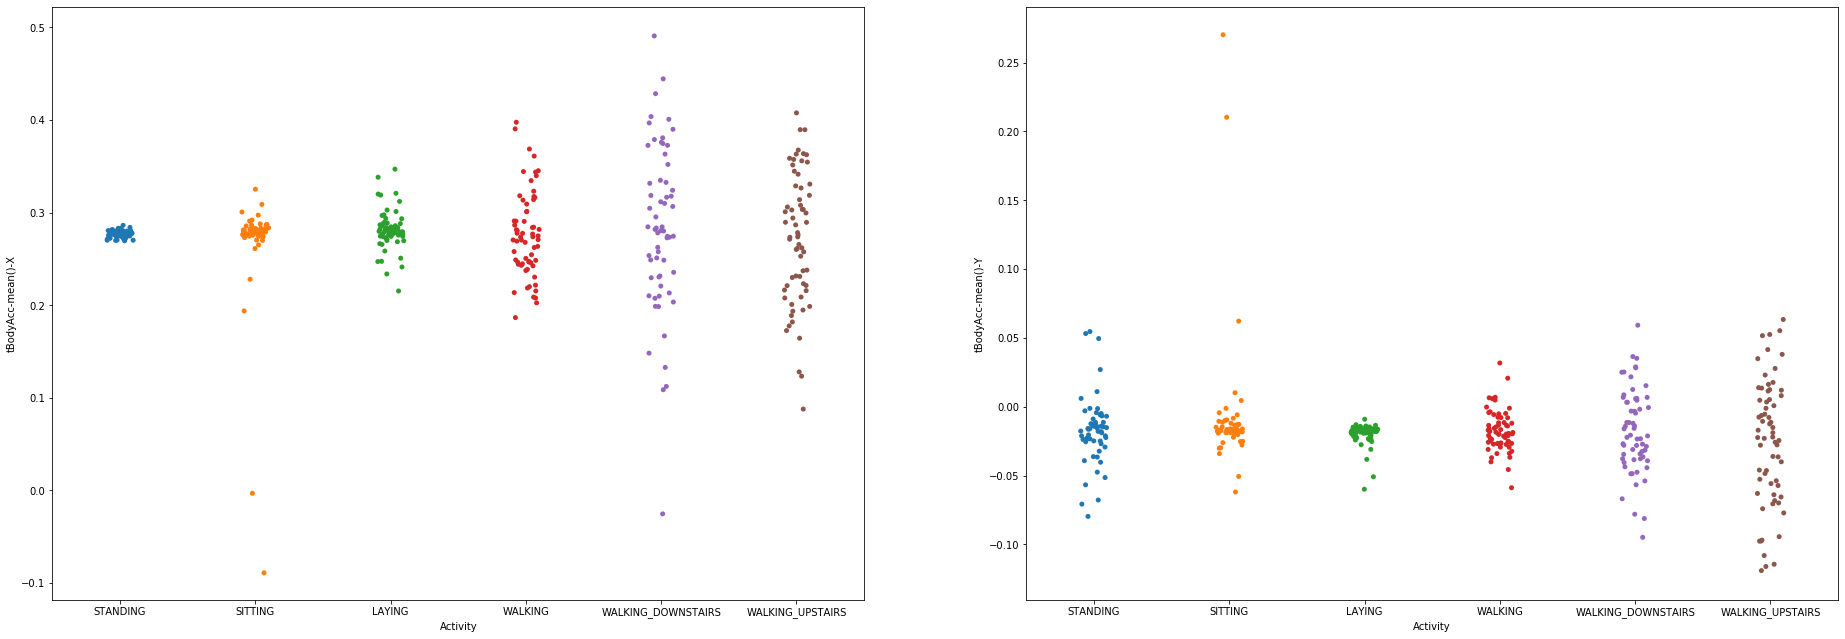

In [11]:
fig = plt.figure(figsize=(32,24))
ax1 = fig.add_subplot(221)
ax1 = sb.stripplot(x='Activity', y=sub15.iloc[:,0], data=sub15, jitter=True)
ax2 = fig.add_subplot(222)
ax2 = sb.stripplot(x='Activity', y=sub15.iloc[:,1], data=sub15, jitter=True)
plt.show()

So, the mean body acceleration is more variable for walking activities than for passive ones especially in the X direction. Let's create a dendrogram and see if we can discover any structure with mean body acceleration.

## **PCA**


El PCA revela que los primeros 100 componentes explican un 97% de la varianza de los datos, sin embargo por lo pequeño del dataset se usaran todas las variables.
El PCA revela que los primeros 100 componentes explican un 97% de la varianza de los datos, sin embargo por lo pequeño del dataset se usaran todas las variables.

In [0]:
le = LabelEncoder()

X_train = train.iloc[:,0:(train.shape[1]-2)].values
y_train = le.fit_transform(train.iloc[:,train.shape[1]-1].values)


X_test = test.iloc[:,0:(test.shape[1]-2)].values
y_test = le.transform(test.iloc[:,test.shape[1]-1].values)

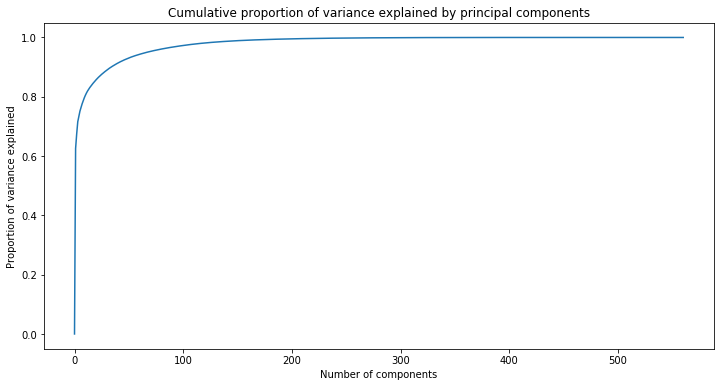

In [67]:
pca = PCA(n_components=X_train.shape[1])

pca.fit(X_train)
cumulative_variance = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(X_train.shape[1])]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(cumulative_variance)
ax.set_title('Cumulative proportion of variance explained by principal components')
ax.set_xlabel('Number of components')
ax.set_ylabel('Proportion of variance explained')

plt.show()

In [0]:
X_pca=pca.transform(X_train) 

In [116]:
ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio) 

[0.92717938 0.07282062]


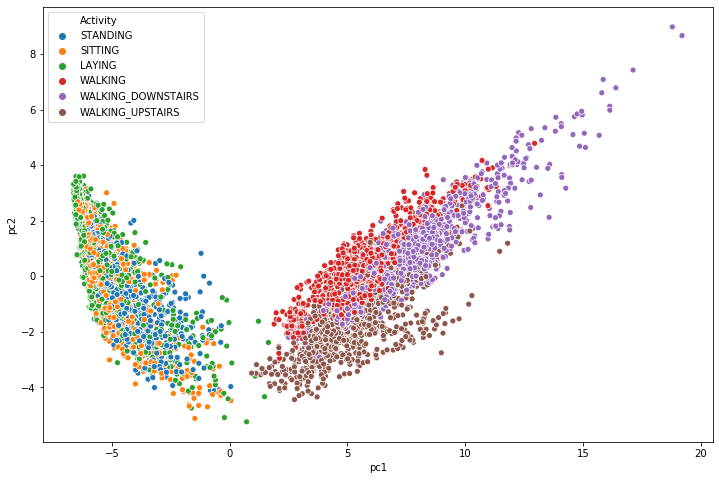

In [131]:

principalDf = pd.DataFrame(X_pca,columns=['pc1','pc2'])
finalDf=pd.concat([principalDf,y_train],axis=1)
plt.figure(figsize=(12,8))
sb.scatterplot(x='pc1',y='pc2',data=principalDf,hue=train['Activity'])

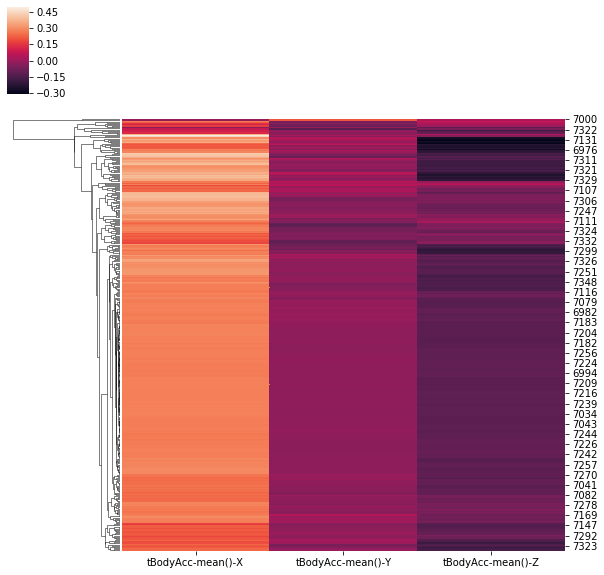

In [17]:
sb.clustermap(sub15.iloc[:,[0,1,2]], col_cluster=False)

Even though we see some dark spots in the X and Z directions (possibly from the walking activities), the bulk of the map is pretty homogenous and does not help much. Perhaps other attributes like maximum or minimum acceleration might give us a better insight than the average.

Plotting maximum acceleration with activity.

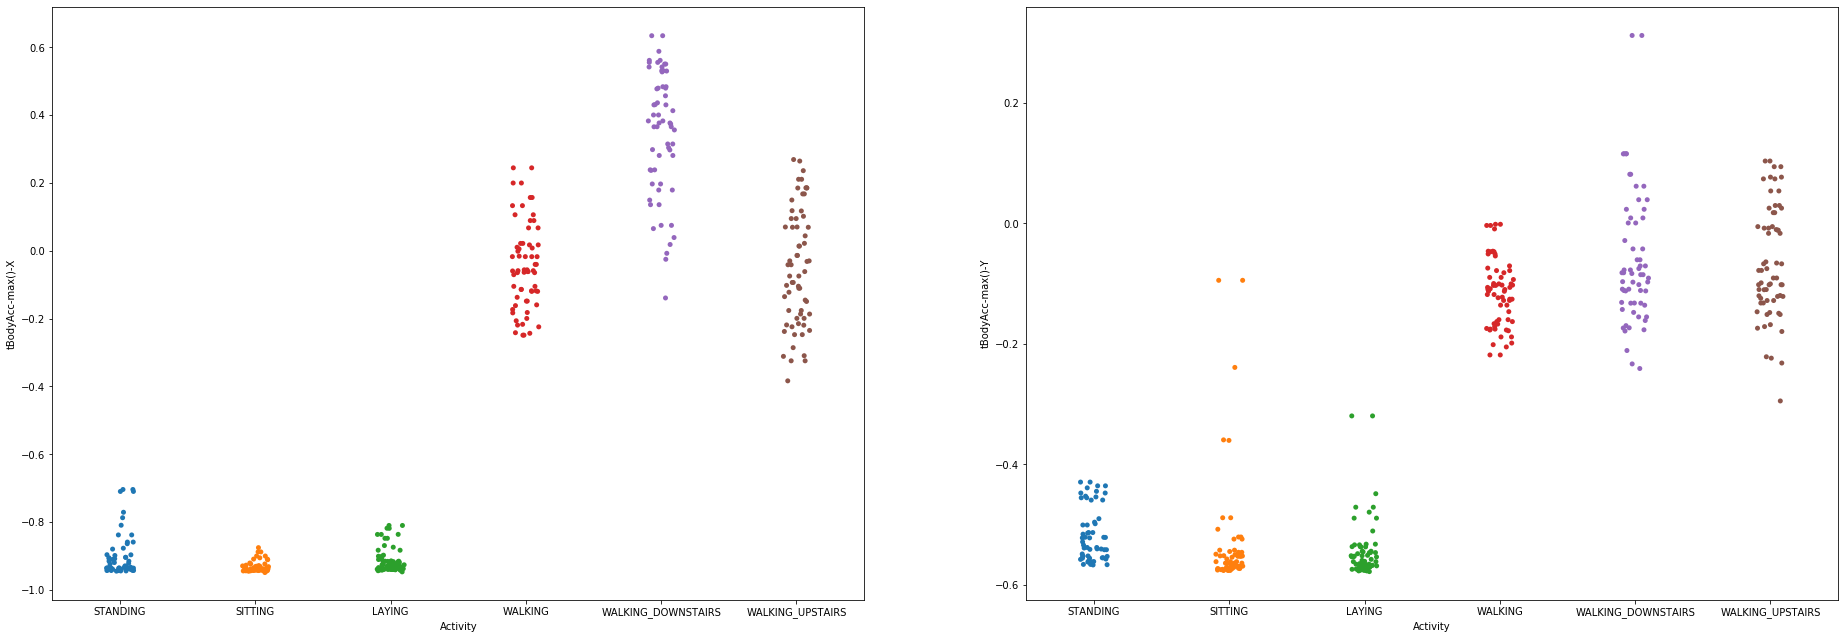

In [18]:
fig = plt.figure(figsize=(32,24))
ax1 = fig.add_subplot(221)
ax1 = sb.stripplot(x='Activity', y='tBodyAcc-max()-X', data=sub15, jitter=True)
ax2 = fig.add_subplot(222)
ax2 = sb.stripplot(x='Activity', y='tBodyAcc-max()-Y', data=sub15, jitter=True)
plt.show()

That's interesting! Passive activities fall mostly below the active ones. It actually makes sense that maximum acceleration is higher during the walking activities. Let's again plot the cluster map but this time with maximum acceleration. Notice the walkdown acitivity is above all others in the X-direction recording values between 0.5 and 0.8.

We can now see the difference in the distribution between the active and passive activities with the walkdown activity (values between 0.5 and 0.8) clearly distinct from all others especially in the X-direction. The passive activities are indistinguishable and present no clear pattern in any direction (X, Y, Z).

### Clustering using KMeans
Now, let us cluster the entire data using KMeans algorithm.

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(sub15.iloc[:,:-2])
clust = pd.crosstab(kmeans.labels_, sub15['Activity'])
clust

Activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
row_0,,,,,,
0,70,0,0,0,0,0
1,0,0,0,0,62,0
2,0,46,17,0,0,0
3,0,0,0,0,0,65
4,0,16,42,0,0,0
5,0,0,0,65,0,0


Upon clustering using kmeans, all the walking activities seem to separate out while the passive ones are still mixed. All three Laying, Sitting and Standing are distributed in two different clusters. 

In [20]:
kmeans.cluster_centers_.shape

(6, 561)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/numpy/lib/type_check.py:581: FutureWarning: `item` has been deprecated and will be removed in a future version
  return a.item()


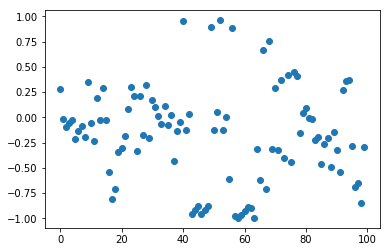

In [0]:
plt.plot(kmeans.cluster_centers_[np.asscalar(clust[clust.WALKING_DOWNSTAIRS!=0].index),:100], "o")

Here is a plot of first 100 columns for the cluster mapped to 'WALKING_DOWNSTAIRS' acitivity. The column 40 and a few around 50 seems to be the dominant columns for this cluster center. Let's see what these are.

In [21]:
print(sub15.columns[[40, 49, 50, 51]])

Index(['tGravityAcc-mean()-X', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y',
       'tGravityAcc-max()-Z'],
      dtype='object')


So, the different aspects of gravity have the most effect on walking down activity which makes perfect sense. 

Even though we could not find a clear pattern with any of the passive activities from the analysis so far, it can be inferred that the sensory measurements seem pretty good in order to train a machine and make predictions on new examples.

**Preprocesamiento**


 **Visualización**
Antes de continuar se realizara un ejercicio con  t -SNE (Corresponde una técnica de reducción de dimensionalidad con el fin de facilitar la visualización de altos conjuntos de datos)

In [0]:
tsne = TSNE()

X_reduced = tsne.fit_transform(train)

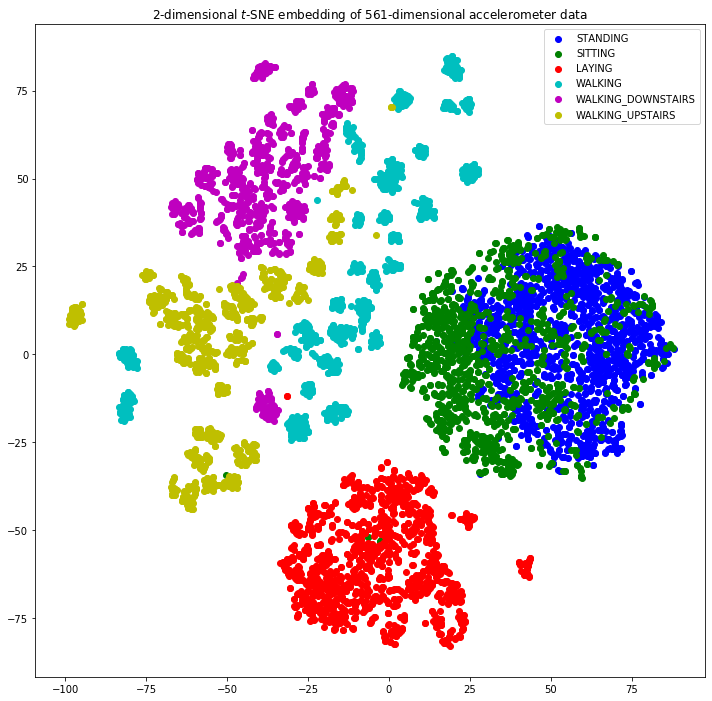

In [32]:
tsne_data = pd.DataFrame(
    {'X':X_reduced[:,0], 'Y':X_reduced[:,1], 
     'activity':train['Activity']})

activities = list(tsne_data['activity'].unique())
colormap = ['b', 'g', 'r', 'c', 'm', 'y']

fig, ax = plt.subplots(figsize=(12,12))
for i in range(len(activities)):
    plot_data = tsne_data.loc[tsne_data['activity'] == activities[i]]
    ax.scatter('X', 'Y', data=plot_data, color=colormap[i], label=activities[i])
ax.set_title('2-dimensional $t$-SNE embedding of 561-dimensional accelerometer data')
ax.legend()

plt.show()

## Training
In this section, I am going to train a model in TensorFlow using the train set and predict the activity using the test set.

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# load train and test data
num_labels = 6
train_x = np.asarray(train.iloc[:,:-2])
train_y = np.asarray(train.iloc[:,562])
act = np.unique(train_y)
for i in np.arange(num_labels):
    np.put(train_y, np.where(train_y==act[i]), i)
train_y = np.eye(num_labels)[train_y.astype('int')] # one-hot encoding

test_x = np.asarray(test.iloc[:,:-2])
test_y = np.asarray(test.iloc[:,562])
for i in np.arange(num_labels):
    np.put(test_y, np.where(test_y==act[i]), i)
test_y = np.eye(num_labels)[test_y.astype('int')]

# shuffle the data
seed = 456
np.random.seed(seed)
np.random.shuffle(train_x)
np.random.seed(seed)
np.random.shuffle(train_y)
np.random.seed(seed)
np.random.shuffle(test_x)
np.random.seed(seed)
np.random.shuffle(test_y)


In [0]:
print(train)

      tBodyAcc-mean()-X  tBodyAcc-mean()-Y  ...  subject  Activity
0              0.288585          -0.020294  ...        1         2
1              0.278419          -0.016411  ...        1         2
2              0.279653          -0.019467  ...        1         2
3              0.279174          -0.026201  ...        1         2
4              0.276629          -0.016570  ...        1         2
...                 ...                ...  ...      ...       ...
7347           0.299665          -0.057193  ...       30         5
7348           0.273853          -0.007749  ...       30         5
7349           0.273387          -0.017011  ...       30         5
7350           0.289654          -0.018843  ...       30         5
7351           0.351503          -0.012423  ...       30         5

[7352 rows x 563 columns]


### Softmax Classifier

Training a softmax classifier and using gradient descent to optimize the weights.

In [0]:
# place holder variable for x with number of features - 561
x = tf.placeholder('float', [None, 561], name='x')
# place holder variable for y with the number of activities - 6
y = tf.placeholder('float', [None, 6], name='y')
# softmax model
def train_softmax(x):
    W = tf.Variable(tf.zeros([561, 6]), name='weights')
    b = tf.Variable(tf.zeros([6]), name='bias')
    lr = 0.25
    prediction = tf.nn.softmax(tf.matmul(x, W) + b, name='op_predict')
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = y))
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    for epoch in range(1000):
        loss = 0
        _, c = sess.run([optimizer, cost], feed_dict = {x: train_x, y: train_y})
        loss += c
        if (epoch % 100 == 0 and epoch != 0):
            print('Epoch', epoch, 'completed out of', 1000, 'Training loss:', loss)
    correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='op_accuracy')
    
    print('Train set Accuracy:', sess.run(accuracy, feed_dict = {x: train_x, y: train_y}))
    print('Test set Accuracy:', sess.run(accuracy, feed_dict = {x: test_x, y: test_y}))

In [83]:
train_softmax(x)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 100 completed out of 1000 Training loss: 1.2866888046264648
Epoch 200 completed out of 1000 Training loss: 1.2237828969955444
Epoch 300 completed out of 1000 Training loss: 1.171236276626587
Epoch 400 completed out of 1000 Training loss: 1.1561753749847412
Epoch 500 completed out of 1000 Training loss: 1.1465312242507935
Epoch 600 completed out of 1000 Training loss: 1.138942837715149
Epoch 700 completed out of 1000 Training loss: 1.1326171159744263
Epoch 800 completed out of 1000 Training loss: 1.1271470785140991
Epoch 900 completed out of 1000 Training loss: 1.1223018169403076
Train set Accuracy: 0.95198584
Test set Accuracy: 0.9331524


After training for 1000 iterations, we got a test accuracy of approximately 93% from softmax classifier

### Neural Network Classifier

Training using a simple artificial neural network with one hidden layer

In [0]:
n_nodes_input = 561 # number of input features
n_nodes_hl = 30     # number of units in hidden layer
n_classes = 6       # number of activities
x = tf.placeholder('float', [None, 561])
y = tf.placeholder('float')

In [0]:
def neural_network_model(data):
    # define weights and biases for all each layer
    hidden_layer = {'weights':tf.Variable(tf.truncated_normal([n_nodes_input, n_nodes_hl], stddev=0.3)),
                      'biases':tf.Variable(tf.constant(0.1, shape=[n_nodes_hl]))}
    output_layer = {'weights':tf.Variable(tf.truncated_normal([n_nodes_hl, n_classes], stddev=0.3)),
                    'biases':tf.Variable(tf.constant(0.1, shape=[n_classes]))}
    # feed forward and activations
    l1 = tf.add(tf.matmul(data, hidden_layer['weights']), hidden_layer['biases'])
    l1 = tf.nn.sigmoid(l1)
    output = tf.matmul(l1, output_layer['weights']) + output_layer['biases']
    
    return output

In [0]:
def train_neural_network(x):
    prediction = neural_network_model(x)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=prediction))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    for epoch in range(1000):
        loss = 0
        _, c = sess.run([optimizer, cost], feed_dict = {x: train_x, y: train_y})
        loss += c
        if (epoch % 100 == 0 and epoch != 0):
            print('Epoch', epoch, 'completed out of', 1000, 'Training loss:', loss)
    correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='op_accuracy')
    
    print('Train set Accuracy:', sess.run(accuracy, feed_dict = {x: train_x, y: train_y}))
    print('Test set Accuracy:', sess.run(accuracy, feed_dict = {x: test_x, y: test_y}))

In [89]:
train_neural_network(x)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 100 completed out of 1000 Training loss: 0.3690779507160187
Epoch 200 completed out of 1000 Training loss: 0.2994857728481293
Epoch 300 completed out of 1000 Training loss: 0.25300541520118713
Epoch 400 completed out of 1000 Training loss: 0.22023586928844452
Epoch 500 completed out of 1000 Training loss: 0.1936781406402588
Epoch 600 completed out of 1000 Training loss: 0.1663602739572525
Epoch 700 completed out of 1000 Training loss: 0.14145247638225555
Epoch 800 completed out of 1000 Training loss: 0.12154900282621384
Epoch 900 completed out of 1000 Training loss: 0.10567118227481842
Train set Accuracy: 0.96055496
Test set Accuracy: 0.94027823


Training using the neural network gave us a test accuracy of about 95%. Notice that I did not specify any learning rate here and used just the default from tensorflow. 

In [98]:
 y_pred = train_neural_network(x)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 100 completed out of 1000 Training loss: 0.3269526958465576
Epoch 200 completed out of 1000 Training loss: 0.2518053352832794
Epoch 300 completed out of 1000 Training loss: 0.19796647131443024
Epoch 400 completed out of 1000 Training loss: 0.16218003630638123
Epoch 500 completed out of 1000 Training loss: 0.1355481892824173
Epoch 600 completed out of 1000 Training loss: 0.11379718035459518
Epoch 700 completed out of 1000 Training loss: 0.0954417735338211
Epoch 800 completed out of 1000 Training loss: 0.08142922818660736
Epoch 900 completed out of 1000 Training loss: 0.06998193264007568
Train set Accuracy: 0.9706202
Test set Accuracy: 0.95622665


In [0]:
 sk.metrics.roc_auc_score(y, y_pred)

NotImplementedError: ignored